# **The Movies Dataset Preprocessing for Heterogeneous Graph Construction**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import ast
from collections import defaultdict

path = kagglehub.dataset_download('rounakbanik/the-movies-dataset')
sns.set_palette(sns.color_palette('CMRmap'))

Using Colab cache for faster access to the 'the-movies-dataset' dataset.


In [2]:
df_metadata = pd.read_csv(f'{path}/movies_metadata.csv', low_memory=False)
df_credits = pd.read_csv(f'{path}/credits.csv')
df_ratings = pd.read_csv(f'{path}/ratings.csv')
df_links = pd.read_csv(f'{path}/links.csv')

#### **Processing Films Metadata**

In [3]:
df_metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [4]:
df_metadata = df_metadata[['imdb_id', 'title', 'genres', 'popularity', 'vote_average', 'vote_count', 'adult']]
df_metadata.head()

,imdb_id,title,genres,popularity,vote_average,vote_count,adult
0,tt0114709,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.946943,7.7,5415.0,False
1,tt0113497,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",17.015539,6.9,2413.0,False
2,tt0113228,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",11.7129,6.5,92.0,False
3,tt0114885,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.859495,6.1,34.0,False
4,tt0113041,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",8.387519,5.7,173.0,False


In [5]:
df_metadata = df_metadata.drop_duplicates(subset=['imdb_id'], keep=False).reset_index(drop=True)

df_metadata = df_metadata[~df_metadata.imdb_id.isna()]
df_metadata = df_metadata[df_metadata.imdb_id != '0']

mapping_imdbId_to_movieId = {}
for idx, row in df_links.iterrows():
  mapping_imdbId_to_movieId[row.imdbId] = row.movieId

df_metadata.imdb_id = df_metadata.imdb_id.apply(
    lambda x: mapping_imdbId_to_movieId[np.float64(x[2:])] if np.float64(x[2:]) in mapping_imdbId_to_movieId else pd.NA
)

df_metadata = df_metadata[~df_metadata.imdb_id.isna()]

In [6]:
df_metadata = df_metadata.reset_index(drop=True)

In [7]:
df_metadata = df_metadata.rename(columns={'imdb_id': 'id'})

Deal with nans and transform column types:

In [8]:
pd.DataFrame({
    'nan_count': df_metadata.isna().sum(),
    'dtype': df_metadata.dtypes
})

,nan_count,dtype
id,0,object
title,3,object
genres,0,object
popularity,3,object
vote_average,3,float64
vote_count,3,float64
adult,0,object


In [9]:
# remove rows with unknown titles

removed_df_metadata = df_metadata[df_metadata.title.isna()].id
df_metadata = df_metadata[~df_metadata.id.isin(removed_df_metadata)]
print(f'Removed {len(removed_df_metadata)} rows with ids: {removed_df_metadata.tolist()}')

Removed 3 rows with ids: [np.float64(97919.0), np.float64(132579.0), np.float64(149854.0)]


In [10]:
df_metadata.adult.unique()

array(['False', 'True'], dtype=object)

In [11]:
df_metadata.adult = df_metadata.adult == 'True'

In [12]:
df_metadata.id = df_metadata.id.astype('int32')
df_metadata.popularity = df_metadata.popularity.astype('float64')

In [13]:
df_metadata[df_metadata.popularity.isna()] = df_metadata.popularity.median()
df_metadata[df_metadata.vote_average.isna()] = df_metadata.vote_average.median()
print(f'Remained nans: {df_metadata.isna().sum().sum()}')

Remained nans: 0


In [14]:
# no genres lookup

df_metadata.loc[:, 'genres'] = df_metadata['genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

empty_genres_count = df_metadata.genres.map(lambda x: len(x) == 0).sum()
print(f'Empty genres: {round(empty_genres_count / df_metadata.shape[0] * 100, 2)}%')

Empty genres: 5.37%


Analyze features:

In [15]:
df_metadata.describe()

,id,popularity,vote_average,vote_count
count,45321.000000,45321.000000,45321.000000,45321.000000
mean,96652.010348,2.924278,5.620132,110.147614
std,57307.613607,6.012087,1.921046,492.032318
min,1.000000,0.000000,0.000000,0.000000
25%,48972.000000,0.386889,5.000000,3.000000
50%,109093.000000,1.129080,6.000000,10.000000
75%,145487.000000,3.684396,6.800000,34.000000
max,176279.000000,547.488298,10.000000,14075.000000


In [16]:
# percentage of adult films

print(f'There are {round(df_metadata.adult.sum() / df_metadata.shape[0] * 100, 3)}% of adult films')

There are 0.018% of adult films


In [17]:
# delete adult films and the feature

df_metadata = df_metadata[~df_metadata.adult]
df_metadata.drop('adult', axis=1);

In [18]:
df_genres = pd.DataFrame({
    'id': df_metadata.id,
    'genres': df_metadata.genres.apply(lambda x: [d['name'] for d in x]),
    'count': df_metadata.genres.apply(lambda x: len([d['name'] for d in x]))
})
genres = set()
genres_amount = dict()

for idx, row in df_genres.iterrows():
  genres |= set(row.genres)

for idx, row in df_genres.iterrows():
  for g in row['genres']:
    if g in genres_amount:
      genres_amount[g] += 1
    else:
      genres_amount[g] = 0

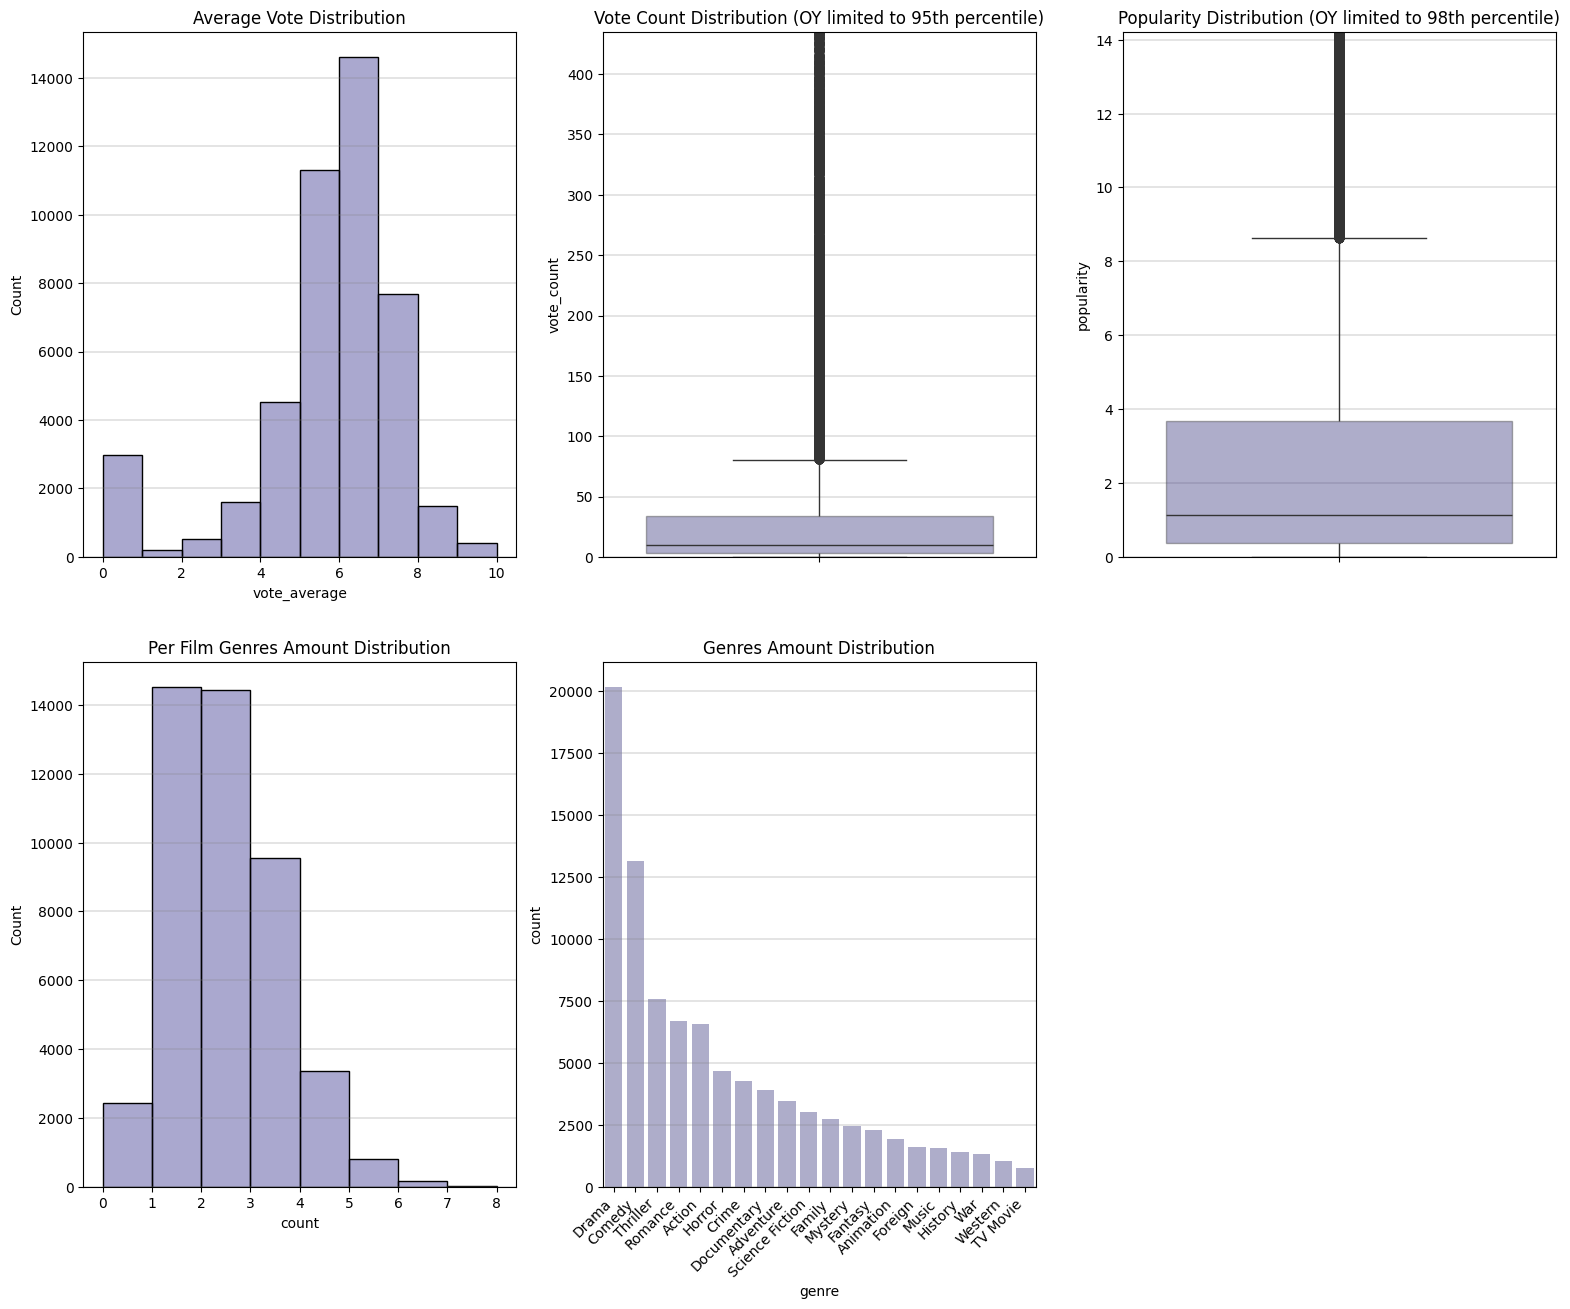

In [24]:
# draw plots for features

fig, axes = plt.subplots(2, 3, figsize=(19, 15))

axes[0, 0].grid(axis='y', color='grey', linewidth=0.3)
axes[0, 1].grid(axis='y', color='grey', linewidth=0.3)
axes[0, 2].grid(axis='y', color='grey', linewidth=0.3)
axes[1, 0].grid(axis='y', color='grey', linewidth=0.3)
axes[1, 1].grid(axis='y', color='grey', linewidth=0.3)

plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

axes[0, 1].set_ylim(0, df_metadata.vote_count.quantile(0.95))
axes[0, 2].set_ylim(0, df_metadata.popularity.quantile(0.98))

axes[1, 2].set_visible(False)

axes[0, 0].set_title('Average Vote Distribution')
axes[0, 1].set_title('Vote Count Distribution (OY limited to 95th percentile)')
axes[0, 2].set_title('Popularity Distribution (OY limited to 98th percentile)')
axes[1, 0].set_title('Per Film Genres Amount Distribution')
axes[1, 1].set_title('Genres Amount Distribution')

sns.histplot(data=df_metadata.drop('genres', axis=1), x='vote_average', bins=10, alpha=0.4, ax=axes[0, 0])
sns.boxplot(data=df_metadata.drop('genres', axis=1), y='vote_count', boxprops=dict(alpha=0.4), ax=axes[0, 1])
sns.boxplot(data=df_metadata.drop('genres', axis=1), y='popularity', boxprops=dict(alpha=0.4), ax=axes[0, 2])
sns.histplot(data=df_genres, x='count', bins=8, alpha=0.4, ax=axes[1, 0])
sns.barplot(
    data=pd.DataFrame(list(genres_amount.items()), columns=['genre','count']).sort_values('count', ascending=False),
    x='genre',
    y='count',
    alpha=0.4,
    ax=axes[1, 1]
)

plt.show()

Apply `log` to `vote_count`:

In [25]:
df_metadata.vote_count = np.log1p(df_metadata.vote_count)

#### **Processing Links**

In [26]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Lookup:

In [27]:
pd.DataFrame({
    'nan_count': df_links.isna().sum(),
    'dtype': df_links.dtypes
})

,nan_count,dtype
movieId,0,int64
imdbId,0,int64
tmdbId,219,float64


#### **Processing Ratings**

In [28]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


Lookup:

In [29]:
pd.DataFrame({
    'nan_count': df_ratings.isna().sum(),
    'dtype': df_ratings.dtypes
})

,nan_count,dtype
userId,0,int64
movieId,0,int64
rating,0,float64
timestamp,0,int64


In [30]:
df_ratings = df_ratings[df_ratings.movieId.isin(df_metadata.id)].reset_index(drop=True)

In [31]:
df_user_ratings = df_ratings.groupby('userId').movieId.count().to_frame().rename(columns={'movieId': 'count'})

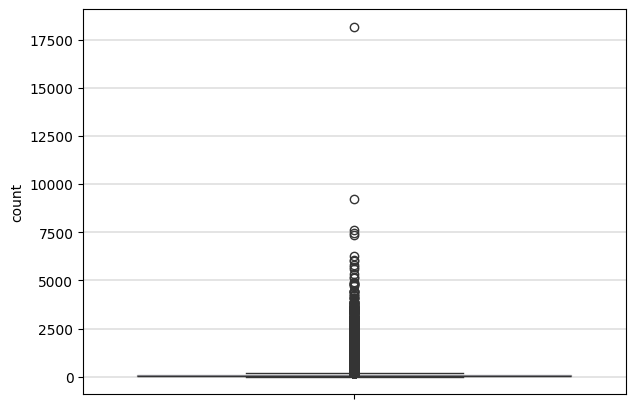

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df_user_ratings, y='count', boxprops=dict(alpha=0.4), ax=ax)

ax.grid(axis='y', color='grey', linewidth=0.3)

plt.show()

In [33]:
chosen_users = df_user_ratings.query('count > count.quantile(0.35) & count < count.quantile(0.65)').index.tolist()

chosen_movies = set(df_ratings[df_ratings.userId.isin(chosen_users)].movieId)
chosen_movies = list(chosen_movies)

print(f'Total chosen movies: {len(chosen_movies)}')
print(f'Total chosen users: {len(chosen_users)}')

Total chosen movies: 16409
Total chosen users: 75680


#### **1.2 Processing Credits**

In [34]:
pd.DataFrame({
    'nan_count': df_credits.isna().sum(),
    'dtype': df_credits.dtypes
})

,nan_count,dtype
cast,0,object
crew,0,object
id,0,int64


In [35]:
# df_credits[df_credits.id.duplicated(keep='last')]
df_credits = df_credits.drop_duplicates(subset=['id'], keep='first')

In [36]:
mapping_tmdbId_to_movieId = {}
for idx, row in df_links.iterrows():
  mapping_tmdbId_to_movieId[row.tmdbId] = row.movieId

df_credits.loc[:, 'id'] = df_credits.id.map(
    lambda x: mapping_tmdbId_to_movieId[x] if x in mapping_tmdbId_to_movieId else pd.NA
)

In [37]:
# filter credits by the chosen movies

df_credits = df_credits[df_credits.id.isin(chosen_movies)]

In [38]:
df_credits.cast = df_credits.cast.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_credits.crew = df_credits.crew.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [39]:
empty_cast_count = df_credits.cast.map(lambda x: len(x) == 0).sum()
empty_crew_count = df_credits.crew.map(lambda x: len(x) == 0).sum()
empty_crew_and_cast_count = (df_credits.cast.map(lambda x: len(x) == 0) & df_credits.crew.map(lambda x: len(x) == 0)).sum()

print(f'Films without cast description: {round(empty_cast_count / df_credits.shape[0] * 100, 2)}%')
print(f'Films without crew description: {round(empty_crew_count / df_credits.shape[0] * 100, 2)}%')
print(f'Films both w/o crew and cast descriptions: {round(empty_crew_and_cast_count / df_credits.shape[0] * 100, 2)}%')

Films without cast description: 1.98%
Films without crew description: 0.54%
Films both w/o crew and cast descriptions: 0.27%


#### **Data Filtering**

In [41]:
df_metadata = df_metadata[df_metadata.id.isin(chosen_movies)]
df_ratings = df_ratings[df_ratings.movieId.isin(chosen_movies) & df_ratings.userId.isin(chosen_users)]

#### **Adding Connections**

df_connections_actors

df_connections_movie_actor

In [42]:
min_appearances = 10
top_n_per_movie = 10

actors_dict = defaultdict(lambda: {
    'actor_id': None,
    'total_films': 0,
    'total_order_sum': 0,
    'gender': 0
})

movie_actor_edges = []

for _, row in df_credits.iterrows():
    movie_id = row.id
    cast_list = row.cast

    if not cast_list:
        continue

    sorted_cast = sorted(cast_list, key=lambda x: x.get('order', 999))[:top_n_per_movie]

    for actor in sorted_cast:
        actor_id = actor['id']
        order = actor.get('order', 999)

        if actor_id not in actors_dict:
            actors_dict[actor_id]['actor_id'] = actor_id
            actors_dict[actor_id]['gender'] = actor.get('gender', 0)

        actors_dict[actor_id]['total_films'] += 1
        actors_dict[actor_id]['total_order_sum'] += order

        movie_actor_edges.append({
            'movie_id': movie_id,
            'actor_id': actor_id,
            'order': order,
            'weight': 1.0 / (order + 1)
        })

actors_list = []
for actor_id, info in actors_dict.items():
    if info['total_films'] >= min_appearances:
        info['avg_order'] = info['total_order_sum'] / info['total_films'] if info['total_films'] > 0 else 999
        actors_list.append(info)

df_connections_actors = pd.DataFrame(actors_list)[['actor_id', 'total_films', 'avg_order', 'gender']]
df_connections_movie_actor = pd.DataFrame(movie_actor_edges)
df_connections_movie_actor = df_connections_movie_actor[df_connections_movie_actor['actor_id'].isin(df_connections_actors['actor_id'])]

print(f"Amount of unique actors: {len(df_connections_actors)}")
print(f"Amount of movie-actor edges: {len(df_connections_movie_actor)}")

Amount of unique actors: 2517
Amount of movie-actor edges: 48106


In [43]:
df_connections_actors.head()

,actor_id,total_films,avg_order,gender
0,31,56,0.803571,2
1,12898,20,0.400000,2
2,7167,14,4.071429,2
3,12899,12,1.083333,2
4,12900,39,5.769231,2


In [44]:
df_connections_movie_actor.head()

,movie_id,actor_id,order,weight
0,1,31,0,1.000000
1,1,12898,1,0.500000
2,1,7167,2,0.333333
3,1,12899,3,0.250000
4,1,12900,4,0.200000


df_connections_directors

df_connections_movie_director

In [45]:
min_appearances = 3

directors_dict = defaultdict(lambda: {
    'director_id': None,
    'total_films': 0,
    'gender': 0
})

movie_director_edges = []

for _, row in df_credits.iterrows():
    movie_id = row['id']
    crew_list = row['crew']

    if not crew_list:
        continue

    directors_in_movie = [person for person in crew_list if person.get('job') == 'Director']

    for director in directors_in_movie:
        director_id = director['id']
        gender = director.get('gender', 0)

        if director_id not in directors_dict:
            directors_dict[director_id]['director_id'] = director_id
            directors_dict[director_id]['gender'] = gender

        directors_dict[director_id]['total_films'] += 1

        movie_director_edges.append({
            'movie_id': movie_id,
            'director_id': director_id
        })

directors_list = []
for director_id, info in directors_dict.items():
    if info['total_films'] >= min_appearances:
        directors_list.append(info)

df_connections_directors = pd.DataFrame(directors_list)[['director_id', 'total_films', 'gender']]
df_connections_movie_director = pd.DataFrame(movie_director_edges)
df_connections_movie_director = df_connections_movie_director[
    df_connections_movie_director['director_id'].isin(df_connections_directors['director_id'])
]

print(f"Amount of unique directors: {len(df_connections_directors)}")
print(f"Amount of movie-director edges: {len(df_connections_movie_director)}")

Amount of unique directors: 1741
Amount of movie-director edges: 10570


In [46]:
df_connections_directors.head()

,director_id,total_films,gender
0,7879,7,2
1,4945,9,2
2,26502,9,2
3,2178,3,2
4,56106,6,2


In [47]:
df_connections_movie_director.head()

,movie_id,director_id
0,1,7879
1,2,4945
2,3,26502
3,4,2178
4,5,56106


df_connections_user_stats

In [48]:
user_stats = df_ratings.groupby('userId').agg({
    'rating': ['count', 'mean'],
    'timestamp': ['min', 'max']
}).reset_index()

user_stats.columns = [
    'userId',
    'numRatings',
    'avgRating',
    'firstRatingDate',
    'lastRatingDate'
]

user_stats['activityDays'] = (
    user_stats['lastRatingDate'] - user_stats['firstRatingDate']
)

df_connections_user_stats = user_stats[['userId', 'numRatings', 'avgRating', 'activityDays']]
df_connections_user_stats = df_connections_user_stats.rename(
    columns={'userId': 'user_id', 'numRatings': 'num_ratings', 'avgRating': 'avg_rating', 'activityDays': 'activity_days'}
)

print(f"Unique users: {len(df_connections_user_stats)}")

Unique users: 75680


In [49]:
df_connections_user_stats.head()

,user_id,num_ratings,avg_rating,activity_days
0,1,27,4.277778,1399
1,2,22,3.318182,2131
2,5,26,4.269231,735
3,7,53,3.367925,591
4,17,24,3.583333,611


df_connections_movie_genre

df_connections_genres

In [50]:
df_genres = df_genres[df_genres.id.isin(chosen_movies)]

In [51]:
genres = sorted(set([g for sublist in df_genres['genres'] for g in sublist]))
genre_name_to_id = {name: idx for idx, name in enumerate(genres)}

movie_genre_edges = []

for _, row in df_genres.iterrows():
    movie_id = row['id']
    movie_genres = row['genres']

    if movie_genres:
      for genre_name in movie_genres:
          if genre_name in genre_name_to_id:
              movie_genre_edges.append({
                  'movie_id': movie_id,
                  'genre_id': genre_name_to_id[genre_name]
              })
    else:
      movie_genre_edges.append({
                  'movie_id': movie_id,
                  'genre_id': -1
              })

df_connections_movie_genre = pd.DataFrame(movie_genre_edges)
df_connections_genres = pd.DataFrame({
    'genre_id': list(genre_name_to_id.values()),
    'genre_name': list(genre_name_to_id.keys())
})

print(f"Unique genres: {len(df_connections_genres)}")
print(f"unique movie-genre edges: {len(df_connections_movie_genre)}")

Unique genres: 20
unique movie-genre edges: 38491


In [52]:
df_connections_genres.head()

,genre_id,genre_name
0,0,Action
1,1,Adventure
2,2,Animation
3,3,Comedy
4,4,Crime


df_connections_user_movie

In [53]:
df_connections_user_movie = df_ratings.reset_index(drop=True)[['userId', 'movieId', 'rating']]. \
                            rename(columns={'userId': 'user_id', 'movieId': 'movie_id'})
df_connections_user_movie.head()

,user_id,movie_id,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


df_connections_movie_features

In [54]:
df_connections_movie_features = df_metadata[['id', 'vote_average', 'vote_count', 'popularity']]. \
                                rename(columns={'id': 'movie_id'})
df_connections_movie_features.head()

,movie_id,vote_average,vote_count,popularity
0,1,7.7,8.597113,21.946943
1,2,6.9,7.789040,17.015539
2,3,6.5,4.532599,11.712900
3,4,6.1,3.555348,3.859495
4,5,5.7,5.159055,8.387519


#### **Save Prepared Data**

In [55]:
import io
import zipfile

dfs = {
    'user_stats.csv': df_connections_user_stats,
    'movie_features.csv': df_connections_movie_features,
    'movie_genre_edges.csv': df_connections_movie_genre,
    'movie_actor_edges.csv': df_connections_movie_actor,
    'movie_director_edges.csv': df_connections_movie_director,
    'user_movie_edges.csv': df_connections_user_movie,
    'actors.csv': df_connections_actors,
    'directors.csv': df_connections_directors,
    'genres.csv': df_connections_genres,
}

with zipfile.ZipFile('graph_data.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
    for name, df in dfs.items():
        buf = io.StringIO()
        df.to_csv(buf, index=False)
        zf.writestr(name, buf.getvalue())
